<a href="https://colab.research.google.com/github/alvarezpablo/NLP-Stocks-Price-Prediction/blob/main/Tesis_LSTM_DESA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from datetime import timedelta
from google.colab import drive

## Configuración para la ejecución

In [45]:
#empresa = 'NETFLIX'
#empresa = 'AMAZON'
#empresa = 'APPLE'
#empresa = 'GOOGLE'
#empresa = 'ACME'

empresa = 'TESLA'
#empresa = 'FACEBOOK'
epochs = 50

## Rutinas

In [46]:
# convierte los datos de entrada en una matriz con la ventana de tiempo
def createDSWindows(dataset, ventana):
  dataX, dataY, dataK, a = [], [], [], []
  for i in range(len(dataset)-ventana-1):
    a = dataset[i:(i+ventana), 1]
    b = dataset[i, 0]
    d = dataset[i,3]
    c = np.concatenate((b,a), axis=None)
#    c = np.concatenate((c,d), axis=None)
    dataX.append(c)
    dataY.append(dataset[i + ventana, 1])
    dataK.append(d)
  
  return np.array(dataX), np.array(dataY), np.array(dataK)

#retorna el proximo día (desde una fecha) sin considerar fines de semana 
def nextDay(fecha):
  proximo = str((datetime.strptime(fecha,"%Y-%m-%d")+timedelta(days=+1)).strftime("%Y-%m-%d"))
  dia = datetime.strptime(proximo,"%Y-%m-%d").weekday()
  if dia == 5:
    proximo = str((datetime.strptime(fecha,"%Y-%m-%d")+timedelta(days=+3)).strftime("%Y-%m-%d"))
  elif dia == 6:
    proximo = str((datetime.strptime(fecha,"%Y-%m-%d")+timedelta(days=+2)).strftime("%Y-%m-%d"))
  else:
    proximo = str((datetime.strptime(fecha,"%Y-%m-%d")+timedelta(days=+1)).strftime("%Y-%m-%d"))
  return proximo

def getPolaridad(fecha, dataframe, delta):
  proximo = str((datetime.strptime(fecha,"%Y-%m-%d")+timedelta(days=+delta)).strftime("%Y-%m-%d"))
  df = dataframe
  df = df.set_index('Date')
  try:
    polaridad = df.loc[[proximo], ['label']]
  except:
    return getPolaridad(fecha, dataframe, delta-1)
  return polaridad.iloc[0,0]

def setRows(dataframe):
  fecha = []
  polaridad = []
  valor = []
  vsemana = []
  mensajes = []
  for i in range(len(dataframe)):
    f = dataframe.iloc[i,0]
    p = dataframe.iloc[i,1]
    v = dataframe.iloc[i,2]
    vs = dataframe.iloc[i,3]
    m = dataframe.iloc[i,4]
    try:
      b = dataframe.iloc[i+1,0]
      next = nextDay(f)
      if next == b:
        fecha.append(f)
        polaridad.append(p)
        valor.append(v)
        vsemana.append(vs)
        mensajes.append(m)
      else: #este caso se da cuando en el dataset no esta el día; feriado
        fecha.append(f)
        fecha.append(next)
        polaridad.append(p)
        valor.append(v)
        vsemana.append(vs)
        mensajes.append(m)
        polaridad.append(getPolaridad(next,dataframe,7))
        valor.append(v)
        vsemana.append(vs)
        mensajes.append(m)
    except: #este caso se da cuando en el dataset no está la polaridad de la fecha que se busca, en ese caso, se usa la polaridad anterior
      fecha.append(f)
      polaridad.append(p)
      valor.append(v)
      vsemana.append(vs)
      mensajes.append(m)
    
    frame = {'Fecha':fecha, 'Polaridad':polaridad, 'Valor':valor, 'VSemana':vsemana, 'Mensajes':mensajes}
    df = pd.DataFrame(frame)
    df = df.set_index('Fecha')

  return df

def getNombreArchivo(accion):
  empresa = ['TESLA', 'GOOGLE', 'FACEBOOK', 'APPLE', 'AMAZON', 'NETFLIX']
  archivo = ['TSLA_label2.1.csv','GOOGL_label2.1.csv','FB_label2.1.csv','AAPL_label2.1.csv','AMZN_label2.1.csv','NFLX_label2.1.csv']
  frame = {'Empresa':empresa, 'Archivo':archivo}
  df =pd.DataFrame(frame)
  df = df.set_index('Empresa')
  archivo = df.loc[[accion],['Archivo']].values[0][0]
  return archivo

def mean_directional_accuracy(actual: np.ndarray, predicted: np.ndarray):
  return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

## Preparación del dataset

In [47]:
# fix random seed
np.random.seed(7)

# carga del dataset
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Magister IA/Tesis/Data/'

archivo = getNombreArchivo(empresa)
df = pd.read_csv(archivo, index_col=False)
df.drop(df[df['Date'] < '2018-07-20'].index, inplace=True)
df.drop(df[df['Date'] > '2020-06-26'].index, inplace=True)
#df = df.drop(['symbol','message','datetime','user','message_id','Time', 'stock_price_1week'], axis='columns')
#df = df.drop(['symbol','message','datetime','user','message_id','Time'], axis='columns')
df = df.drop(['symbol','datetime','user','message_id','Time'], axis='columns')
#df.reset_index(level=0, inplace=True)

df=df.groupby(['Date', 'label', 'stock_price', 'stock_price_1week'])['message'].apply(' '.join).reset_index()
#df = df.set_index('Date')
#feriado = df.loc[['2019-01-01'], ['label', 'message']]
#feriado
#df


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Magister IA/Tesis/Data


In [48]:
#train_data=train_data.groupby(['symbol','Date', 'label', 'stock_price', 'stock_price_1week'])['message'].apply(' '.join).reset_index()


#df = df.groupby(by=['Date']).mean()
df['label'] = df['label'].map({-1:0, 1:1, 0:0}, na_action=None)
#df.reset_index(level=0, inplace=True)


# se consideran 5 días por semana, ya que en el data set no están los fines de semana
dias = 5
#la ventana debería ser igual a días. Sin embargo, hay un dato adicional en el dataset; que es la polaridad. Por eso se agrega 1 al tamaño de la ventana 
ventana = dias+1

newDF = setRows(df)
newDF.isnull().sum()
#feriado = newDF.loc[['2018-12-31','2019-01-01','2019-01-02'], ['Valor', 'Polaridad','VSemana', 'Mensajes']]
#feriado
#newDF

Polaridad    0
Valor        0
VSemana      0
Mensajes     0
dtype: int64

In [49]:
#newDF = newDF.drop(['Mensajes'], axis='columns')
#newDF


In [50]:
dataset = newDF.values
dsVLSTM, dsOLSTM, dsMBERT = createDSWindows(dataset, dias)

#dsVLSTM
#dsOLSTM
#dsMBERT

In [51]:
#dsVLSTM

In [52]:
#dataset = newDF.values
#dsVLSTM_M, dsOLSTM = createDSWindows(dataset, dias)

# split train y test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
trainVLSTM, testVLSTM = dsVLSTM[0:train_size,:], dsVLSTM[train_size:len(dataset),:]
trainOLSTM, testOLSTM = dsOLSTM[0:train_size], dsOLSTM[train_size:len(dataset)]
trainMBERT, testMBERT = dsMBERT[0:train_size], dsMBERT[train_size:len(dataset)]

#trainVLSTM
#trainOLSTM
#testOLSTM
#testMBERT

In [53]:
#dataset = newDF.values
#dataset = dataset.astype('float32')


# split train y test sets
#train_size = int(len(dataset) * 0.67)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape para la ventana
trainX = trainVLSTM
trainY = trainOLSTM
testX = testVLSTM
testY = testOLSTM

# normalización de los sub-datasets
scalerTrX = MinMaxScaler(feature_range=(0, 1))
scalerTrY = MinMaxScaler(feature_range=(0, 1))
scalerTeX = MinMaxScaler(feature_range=(0, 1))
scalerTeY = MinMaxScaler(feature_range=(0, 1))

trainX = scalerTrX.fit_transform(trainX)
testX = scalerTeX.fit_transform(testX)

trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)

trainY = scalerTrY.fit_transform(trainY)
testY = scalerTeY.fit_transform(testY)

trainY = trainY.flatten('F')
testY = testY.flatten('F')

# reshape [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

#trainX

## Configuración y ejecución de la LSTM

In [54]:
batch_size = 1
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, batch_input_shape=(batch_size, ventana, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)

Epoch 1/50
338/338 [==============================] - 10s 11ms/step - loss: 0.0358
Epoch 2/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0102
Epoch 3/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0087
Epoch 4/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0085
Epoch 5/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0076
Epoch 6/50
338/338 [==============================] - 4s 12ms/step - loss: 0.0073
Epoch 7/50
338/338 [==============================] - 4s 12ms/step - loss: 0.0066
Epoch 8/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0074
Epoch 9/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0061
Epoch 10/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0067
Epoch 11/50
338/338 [==============================] - 4s 11ms/step - loss: 0.0059
Epoch 12/50
338/338 [==============================] - 4s 12ms/step - loss: 0.0059
Epoch 13/50


## Resultados

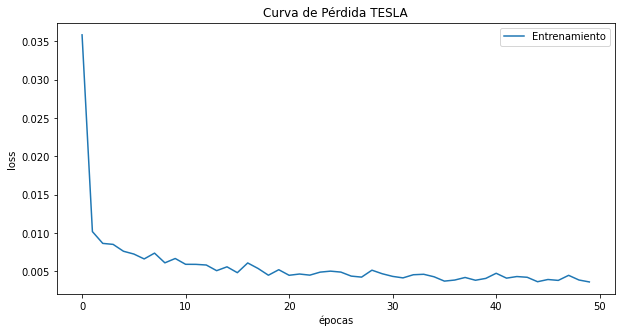

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.title('Curva de Pérdida '+empresa)
plt.xlabel('épocas')
plt.ylabel('loss')
plt.legend()
plt.show()

In [56]:
# predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# se invierten las predicciones
trainPredict = scalerTrY.inverse_transform(trainPredict)
trainYY = scalerTrY.inverse_transform([trainY])
testPredict = scalerTeY.inverse_transform(testPredict)
testYY = scalerTeY.inverse_transform([testY])


# mean absolute error
maeTr = mean_absolute_error(trainYY[0], trainPredict[:,0])
print('Train MAE score: %.2f' % maeTr)
maeTe = mean_absolute_error(testYY[0], testPredict[:,0])
print('Test MAE score: %.2f' % maeTe)

# mean squared error
mseTr = mean_squared_error(trainYY[0], trainPredict[:,0])
print('\nTrain MSE score: %.2f' % mseTr)
mseTe = mean_squared_error(testYY[0], testPredict[:,0])
print('Test MSE score: %.2f' % mseTe)

# root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYY[0], trainPredict[:,0]))
print('\nTrain RMSE score: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYY[0], testPredict[:,0]))
print('Test RMSE score: %.2f' % (testScore))

# mean directional accuracy
mda = mean_directional_accuracy(testYY[0], testPredict)
print('\nTest MDA score: ', "{:.0%}".format(mda))

Train MAE score: 2.02
Test MAE score: 6.87

Train MSE score: 6.64
Test MSE score: 88.69

Train RMSE score: 2.58
Test RMSE score: 9.42

Test MDA score:  47%


In [57]:
dsVLSTM

array([[0, 62.71599960327149, 60.63999938964844, 59.486000061035156,
        61.74800109863281, 61.33000183105469],
       [0, 60.63999938964844, 59.486000061035156, 61.74800109863281,
        61.33000183105469, 59.43600082397461],
       [0, 59.486000061035156, 61.74800109863281, 61.33000183105469,
        59.43600082397461, 58.03400039672852],
       ...,
       [0, 198.17999267578125, 196.42599487304688, 198.3580017089844,
        200.79200744628903, 200.17999267578125],
       [1, 196.42599487304688, 198.3580017089844, 200.79200744628903,
        200.17999267578125, 198.86399841308597],
       [0, 198.3580017089844, 200.79200744628903, 200.17999267578125,
        198.86399841308597, 200.3560028076172]], dtype=object)

In [ ]:
ds

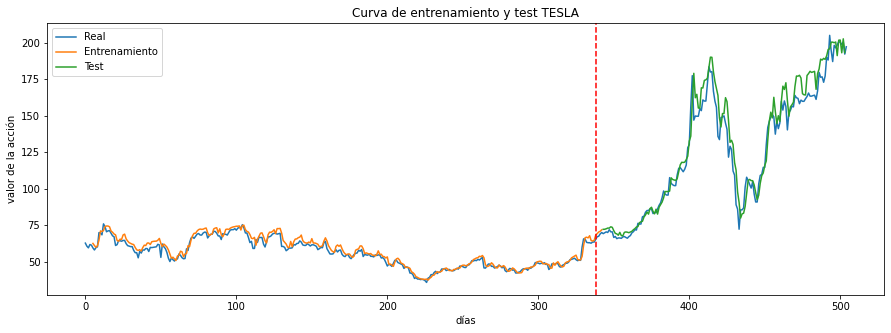

In [66]:
i = 1
columna = [fila[i] for fila in dataset]
ds = np.array(columna)
ds = ds.reshape(-1,1)

trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[dias:len(trainPredict)+dias, :] = trainPredict

testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(dias):len(ds)-1, :] = testPredict

# plot de los datos de entrada y las predicciones
plt.figure(figsize=(15, 5))
plt.plot(ds, label='Real')
plt.title('Curva de entrenamiento y test '+empresa)
plt.plot(trainPredictPlot, label="Entrenamiento")
plt.plot(testPredictPlot, label="Test")
plt.axvline(x=trainPredict.shape[0], c='r', linestyle='--')
plt.xlabel('días')
plt.ylabel('valor de la acción')
plt.legend()
plt.show()